<a href="https://colab.research.google.com/github/xtliao/PyTorchProjects/blob/main/nn_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A ConvNet practice on MNIST dataset


# 1.&nbsp;Prep MNIST dataset and dataloader.




In [135]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1.1. Get the train and test dataset from MNIST dataset

In [136]:
train_dataset = MNIST(root="data",
                      train=True,
                      transform=transforms.ToTensor(),
                      target_transform=None,
                      download=True
                      )
test_dataset = MNIST(root="data",
                      train=False,
                      transform=transforms.ToTensor(),
                      target_transform=None,
                      download=True
                      )

print(f"Length of train dataset: {len(train_dataset):,}\n")
print(f"Length of test dataset: {len(test_dataset):,}\n")

input, label = train_dataset[0]
print(f"Shape of input: {input.shape} \n")
print(f"Lable: {label} \n")

class_names = train_dataset.classes
print(f"There are {len(class_names)} classes in the dataset: \n")
print(f"{class_names}")

Length of train dataset: 60,000

Length of test dataset: 10,000

Shape of input: torch.Size([1, 28, 28]) 

Lable: 5 

There are 10 classes in the dataset: 

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 1.2. Plot some random data from the train dataset

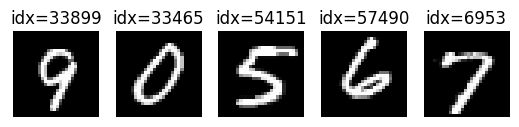

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import random

NUM_SAMPLES = 5
random_sample_ids = random.sample(range(0, len(train_dataset)), k=NUM_SAMPLES)
random_sample_ids

fig, axs = plt.subplots(1, NUM_SAMPLES)
for i, idx in enumerate(random_sample_ids):
  axs[i].imshow(train_dataset[idx][0].squeeze(), cmap="gray")
  axs[i].axis(False)
  axs[i].set_title(f"idx={idx}")


## 1.3 Convert into dataloader

In [138]:
BATCH_SIZE = 32

train_dataloder = DataLoader(dataset=train_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloder = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

print(f"Length of train dataloder: {len(train_dataloder):,}\n")
print(f"Length of test dataloder: {len(test_dataloder):,}\n")


Length of train dataloder: 1,875

Length of test dataloder: 313



# 2.&nbsp;Define training and testing loop functions.

## 2.1 Define train_loop()

In [139]:
def train_loop(model: torch.nn.Module,
               train_dataloder: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               metric_fn,
               device: torch.device = device):
  model.train()
  model.to(device)

  train_loss, train_metric = 0, 0
  for batch, (X, y) in enumerate(train_dataloder):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    loss = loss_fn(y_logits, y)

    y_prob = y_logits.softmax(dim=1).argmax(dim=1)
    metric = metric_fn(y_prob, y)

    train_loss += loss.detach()
    train_metric += metric.detach()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return train_loss/len(train_dataloder), train_metric/len(train_dataloder)


## 2.2 Define test_loop()

In [140]:
def test_loop(model: torch.nn.Module,
              test_dataloder: torch.utils.data.DataLoader,
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module,
              metric_fn,
              device: torch.device = device):
  model.eval()
  model.to(device)

  with torch.inference_mode():
    test_loss, test_metric = 0 ,0
    for batch, (X_test, y_test) in enumerate(test_dataloder):
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_logits = model(X_test)
      loss = loss_fn(test_logits, y_test)

      test_prob = test_logits.softmax(dim=1).argmax(dim=1)
      metric = metric_fn(test_prob, y_test)

      test_loss += loss.detach()
      test_metric += metric.detach()

  return test_loss/len(test_dataloder), test_metric/len(test_dataloder)

# 3.&nbsp;Define training model function to use training and test loop functions.

In [141]:
from tqdm.auto import tqdm

def train_model(model: torch.nn.Module,
                train_dataloder: torch.utils.data.DataLoader,
                test_dataloder: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                metric_fn,
                device: torch.device = device,
                epochs: int = 5):

  results = {"train_loss": [],
            "train_metric": [],
            "test_loss":[],
            "test_metric": []}

  for epoch in tqdm(range(epochs), desc="Training model..."):
    train_loss, train_metric = train_loop(model=model,
                                          train_dataloder=train_dataloder,
                                          optimizer=optimizer,
                                          loss_fn = loss_fn,
                                          metric_fn=metric_fn,
                                          device=device)

    test_loss, test_metric = test_loop(model=model,
                                       test_dataloder=test_dataloder,
                                       optimizer=optimizer,
                                       loss_fn= loss_fn,
                                       metric_fn = metric_fn,
                                       device=device)

    print(f"Epoch:{epoch:3n} | Train loss:{train_loss:.5f}, train metric:{train_metric:.2%} | Test loss:{test_loss:.5f}, test metric:{test_metric:.2%}")

    results["train_loss"].append(train_loss.item())
    results["train_metric"].append(train_metric.item())
    results["test_loss"].append(test_loss.item())
    results["test_metric"].append(test_metric.item())

  return results

# 4.&nbsp;Define model by replicating CNN Explainer: https://poloclub.github.io/cnn-explainer/

## 4.1 Define the model class

In [142]:
import torch.nn as nn

class MyMNISTModel(nn.Module):
  def __init__(self, input_shapes: int, hidden_units: int, output_shapes: int):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shapes,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units,3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
    nn.Conv2d(hidden_units, hidden_units,3, 1, 1),
    nn.ReLU(),
    nn.Conv2d(hidden_units, hidden_units,3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 7 * 7,
                  out_features=output_shapes)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    # print(f"Shape after conv1:{x.shape}")
    x = self.conv2(x)
    # print(f"Shape after conv2:{x.shape}")
    x = self.classifier(x)
    # print(f"Shape after classifier:{x.shape}")
    return x

model_0 = MyMNISTModel(input_shapes=1,
                       hidden_units=10,
                       output_shapes=len(class_names))
model_0


MyMNISTModel(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 4.2 Test the new model

In [143]:
X, y = train_dataset[0]
y_pred = model_0(X.unsqueeze(0)).softmax(dim=1).argmax(dim=1)
print(f"X.shape:{X.shape}, y:{y}, prediction:{y_pred.item()}")

X.shape:torch.Size([1, 28, 28]), y:5, prediction:1


# 5.&nbsp;Define loss function, accuracy function and optimizer.

## 5.1. Use metric functions in trochmetrics package

In [144]:
try:
  import torchmetrics
except:
  !pip install torchmetrics --quiet
  import torchmetrics

## 5.2. Define the functions

In [145]:
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.01)
loss_fn = torch.nn.CrossEntropyLoss()

from torchmetrics.classification import MulticlassAccuracy
acc_fn = MulticlassAccuracy(num_classes=len(class_names))

# 6.&nbsp;Train the model.

In [147]:
import timeit

start = timeit.default_timer()

NUM_EPOCHS = 3

model_0_results = train_model(model=model_0,
                              train_dataloder=train_dataloder,
                              test_dataloder=test_dataloder,
                              optimizer=optimizer,
                              loss_fn = loss_fn,
                              metric_fn=acc_fn,
                              device = device,
                              epochs=NUM_EPOCHS)

end = timeit.default_timer()
model_0_train_time = end-start

print()
print(f"Train time is:{model_0_train_time:.2f} seconds")
print(f"Train results are:")
print(f"Train loss:{model_0_results['train_loss']}")
print(f"Train accuracy:{model_0_results['train_metric']}")
print(f"Test  loss:{model_0_results['test_loss']}")
print(f"Test  accuracy:{model_0_results['test_metric']}")


Training model...:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:  0 | Train loss:0.07905, train metric:97.44% | Test loss:0.06019, test metric:97.81%
Epoch:  1 | Train loss:0.07747, train metric:97.43% | Test loss:0.17864, test metric:94.64%
Epoch:  2 | Train loss:0.07961, train metric:97.37% | Test loss:0.07461, test metric:97.33%

Train time is:174.22 seconds
Train results are:
Train loss:[0.07904668152332306, 0.0774708017706871, 0.07961226254701614]
Train accuracy:[0.9744144678115845, 0.9743195176124573, 0.9737359285354614]
Test  loss:[0.06018560007214546, 0.1786353439092636, 0.0746125876903534]
Test  accuracy:[0.978083610534668, 0.94642174243927, 0.973282516002655]


# 7.&nbsp;Make predictions and eval the model.

## 7.1. Define the make_prediction()

In [148]:
def make_prediction(model: torch.nn.Module,
                    data: torch.utils.data.Dataset,
                    device: torch.device = device):
  model.eval()
  model.to(device)

  with torch.inference_mode():
    pred_probs, pred_labels = [], []
    for sample, label in data:
      sample = sample.to(device)
      pred_prob = model(sample.unsqueeze(0)).softmax(dim=1).argmax(dim=1).item()
      pred_probs.append(pred_prob)
      pred_labels.append(label)
  return pred_probs, pred_labels

## 7.2. Make random predictions

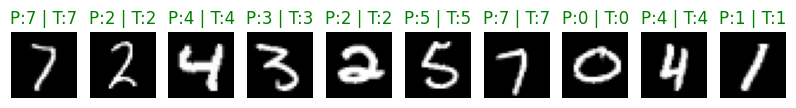

In [149]:
NUM_PLOTS = 10
random_samples = random.sample(list(test_dataset), k=NUM_PLOTS)

random_probs, random_labels = make_prediction(model=model_0,
                                             data=random_samples,
                                             device=device)

fig, axs = plt.subplots(1, NUM_PLOTS, figsize=(10,10))
for i in range(NUM_PLOTS):
  axs[i].axis(False)
  axs[i].imshow(random_samples[i][0].squeeze(), cmap="gray")
  title = f"P:{random_probs[i]} | T:{random_labels[i]}"
  if random_probs[i] == random_labels[i]:
    axs[i].set_title(title, c="green")
  else:
    axs[i].set_title(title, c="red")

# 8.&nbsp;Plot the loss and accuracy curves.

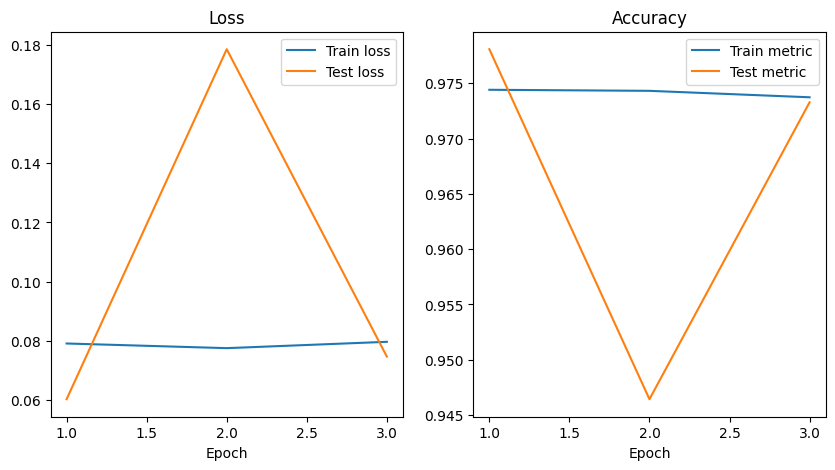

In [150]:
model_0_results
plt.figure(figsize=(10,5))

epochs=range(1, NUM_EPOCHS+1)

# Plot loss
plt.subplot(1,2,1)
plt.plot(epochs, model_0_results["train_loss"], label="Train loss")
plt.plot(epochs, model_0_results["test_loss"], label="Test loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(epochs, model_0_results["train_metric"], label="Train metric")
plt.plot(epochs, model_0_results["test_metric"], label="Test metric")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

# 9.&nbsp;Plot the confusion matrix.

## 9.1. Make prediction for all test_dataset

In [151]:
pred_probs, pred_labels = make_prediction(model=model_0,
                                          data=test_dataset,
                                          device= device)
pred_probs[:5], pred_labels[:5]

([7, 2, 1, 0, 4], [7, 2, 1, 0, 4])

## 9.2. Calculate the confusion matrix and plot it

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

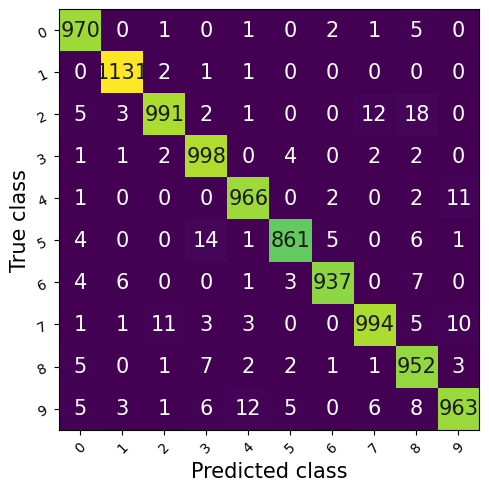

In [152]:
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=len(class_names))
metric.update(torch.tensor(pred_probs), torch.tensor(pred_labels))
metric.plot()

# 10.&nbsp;Plot some of the wrong predictions.

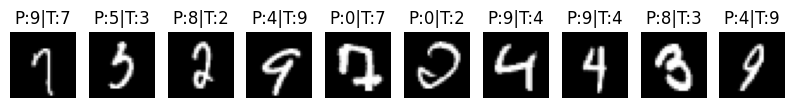

In [177]:
wrong_predictions_ids = []
for i in range(len(pred_probs)):
  if pred_probs[i] != pred_labels[i]:
    wrong_predictions_ids.append(i)

random_ids = random.sample(wrong_predictions_ids, k=NUM_PLOTS)
fig, axs = plt.subplots(1, NUM_PLOTS, figsize=(10,5))

for i, idx in enumerate(random_ids):
  axs[i].imshow(test_dataset[idx][0].squeeze(0), cmap="gray")
  axs[i].axis(False)
  axs[i].set_title(f"P:{pred_probs[idx]}|T:{pred_labels[idx]}")

# 11.&nbsp;Save the model.

## 11.1. Save the state_dict

In [163]:
from pathlib import Path
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "PyTorch_NeuralNetwork_MNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model state_dict to {MODEL_SAVE_PATH}\n")

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)
print(f"list all files in the model folder:")
!ls -l model

Saving model state_dict to model/PyTorch_NeuralNetwork_MNIST.pth

list all files in the model folder:
total 36
-rw-r--r-- 1 root root 35024 Aug 21 00:26 PyTorch_NeuralNetwork_MNIST.pth


## 11.2. Load saved state_dict

In [164]:
new_loaded_model = MyMNISTModel(input_shapes=1,
                                hidden_units=10,
                                output_shapes=len(class_names))
new_loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


MyMNISTModel(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)